In [1]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import copy


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np


from tqdm import trange
from tqdm import tqdm


import copy
import random
import time

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
test_dataset = datasets.MNIST(root = './data', train = False, download = False, transform = transform)

In [3]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9',)

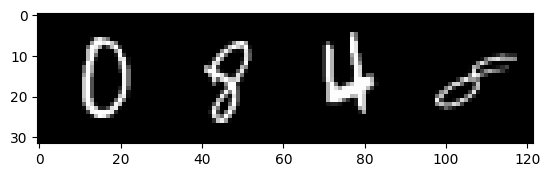

0     8     4     8    


In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next (dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [5]:
mean = train_dataset.data.float().mean() / 255
std = train_dataset.data.float().std() / 255
print(f'Mean: {mean}')
print(f'STD: {std}')

Mean: 0.13066047430038452
STD: 0.30810779333114624


In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding =2),
    transforms.Normalize(mean=[mean], std=[std])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [7]:
train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transform_train)
test_dataset = datasets.MNIST(root = './data', train = False, download = False, transform = transform_test)

In [8]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 60000
Number of testing examples: 10000


In [9]:
Validation = 0.9
train_examples = int(len(train_dataset) * Validation)
validation_examples = len(train_dataset) - train_examples

In [10]:
train_dataset, validation_dataset = data.random_split(train_dataset, [train_examples, validation_examples])

In [11]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(validation_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [12]:
validation_dataset = copy.deepcopy(validation_dataset)
validation_dataset.dataset.transform = transform_test

In [13]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_dataset,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(validation_dataset,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_dataset,
                                batch_size=BATCH_SIZE)

In [14]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(input_dim, 250)
        self.hidden = nn.Linear(250,100)
        self.output = nn.Linear(100, output_dim)
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h1 = F.relu(self.input(x))
        h2 = F.relu(self.hidden(h1))
        y_pred = self.output(h2)
        return y_pred, h2

In [15]:
input_dim = 28*28
output_dim = 10

model = Perceptron(input_dim, output_dim)

In [16]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cude' if torch.cuda.is_available() else 'cpu')

In [17]:
model = model.to(device)
criterion = criterion.to(device)

In [18]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [19]:
def train (model, iterator, optimizer, criterion, device):
    epochLoss = 0
    epochAcc = 0
    model.train()

    for (x,y) in tqdm(iterator, desc = "Training", leave = False):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epochLoss += loss.item()
        epochAcc += acc.item()

        return epochLoss/len(iterator), epochAcc / len(iterator)

In [20]:
def evaluate (model, iterator, criterion, device):
    epochLoss = 0
    epochAcc = 0
    model.eval()
    with torch.no_grad():
          for (x,y) in tqdm(iterator, desc = "Evaluating", leave = False):
                x = x.to(device)
                y = y.to(device)
                y_pred, _ = model(x)
                loss = criterion(y_pred, y)
                acc = calculate_accuracy(y_pred, y)
                epochLoss += loss.item()
                epochAcc += acc.item()
          return epochLoss/len(iterator), epochAcc / len(iterator)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
EPOCHS = 20
best_valid_loss = float('inf')

for epoch in trange(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
  5%|████▏                                                                              | 1/20 [00:00<00:08,  2.13it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.003 | Train Acc: 0.01%
	 Val. Loss: 2.268 |  Val. Acc: 22.52%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 10%|████████▎                                                                          | 2/20 [00:00<00:08,  2.10it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.003 | Train Acc: 0.03%
	 Val. Loss: 2.230 |  Val. Acc: 26.55%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 15%|████████████▍                                                                      | 3/20 [00:01<00:08,  2.07it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.003 | Train Acc: 0.03%
	 Val. Loss: 2.182 |  Val. Acc: 31.68%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 20%|████████████████▌                                                                  | 4/20 [00:01<00:07,  2.11it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.003 | Train Acc: 0.04%
	 Val. Loss: 2.130 |  Val. Acc: 33.42%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 25%|████████████████████▊                                                              | 5/20 [00:02<00:07,  2.08it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.003 | Train Acc: 0.03%
	 Val. Loss: 2.074 |  Val. Acc: 32.79%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 30%|████████████████████████▉                                                          | 6/20 [00:02<00:06,  2.10it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.003 | Train Acc: 0.03%
	 Val. Loss: 2.017 |  Val. Acc: 35.71%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 35%|█████████████████████████████                                                      | 7/20 [00:03<00:06,  2.11it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.003 | Train Acc: 0.03%
	 Val. Loss: 1.955 |  Val. Acc: 38.96%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 40%|█████████████████████████████████▏                                                 | 8/20 [00:03<00:05,  2.13it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 0.03%
	 Val. Loss: 1.889 |  Val. Acc: 44.75%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 45%|█████████████████████████████████████▎                                             | 9/20 [00:04<00:05,  2.14it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 0.05%
	 Val. Loss: 1.826 |  Val. Acc: 51.42%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 50%|█████████████████████████████████████████                                         | 10/20 [00:04<00:04,  2.16it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 0.05%
	 Val. Loss: 1.763 |  Val. Acc: 56.42%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 55%|█████████████████████████████████████████████                                     | 11/20 [00:05<00:04,  2.10it/s]

Epoch: 11 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 0.05%
	 Val. Loss: 1.692 |  Val. Acc: 61.14%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:05<00:03,  2.11it/s]

Epoch: 12 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 0.05%
	 Val. Loss: 1.622 |  Val. Acc: 62.90%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:06<00:03,  2.14it/s]

Epoch: 13 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 0.06%
	 Val. Loss: 1.559 |  Val. Acc: 61.38%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:06<00:02,  2.16it/s]

Epoch: 14 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 0.06%
	 Val. Loss: 1.492 |  Val. Acc: 60.70%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:07<00:02,  2.17it/s]

Epoch: 15 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 0.05%
	 Val. Loss: 1.419 |  Val. Acc: 62.60%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:07<00:01,  2.14it/s]

Epoch: 16 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 0.06%
	 Val. Loss: 1.350 |  Val. Acc: 65.83%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:07<00:01,  2.14it/s]

Epoch: 17 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 0.06%
	 Val. Loss: 1.289 |  Val. Acc: 67.22%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:08<00:00,  2.15it/s]

Epoch: 18 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 0.07%
	 Val. Loss: 1.237 |  Val. Acc: 66.15%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:08<00:00,  2.15it/s]

Epoch: 19 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 0.06%
	 Val. Loss: 1.184 |  Val. Acc: 66.77%



Training:   0%|                                                                                | 0/844 [00:00<?, ?it/s]
                                                                                                                       
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.13it/s]

Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.002 | Train Acc: 0.07%
	 Val. Loss: 1.121 |  Val. Acc: 68.93%
